<a href="https://colab.research.google.com/github/Dilru1/X-ray_Files/blob/main/X_ray_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np 
import sys
from scipy import special
import matplotlib


## Mount Drive

Before mounting the drive click on [this folder](https://drive.google.com/drive/folders/1rXKMGDayWkZCsbHAcIANkZhYYTdqpCjx?usp=sharing) and add it to your google drive by following these steps:

*   Go to your drive 
*   Find shared folder ("Shared with me" link)
*   Right click it
*   "Add Shortcut to Drive"

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
def init():
    # Root - working folder
    global mypath
    mypath ='/content/drive/My Drive/X-ray_project_Data/data/'
    
    # Folder conatining the code and the observation list
    global flux,maps
    flux = mypath+'flux_eff/'
    maps = mypath+ 'maps_eff/'
init()


In [16]:
directory = os.fsencode(maps)
myfiles=[]
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if filename.endswith(".fits") and str(filename)[  (len(str(filename)) -9) : (len(str(filename)) -5) ] in ('2000','2004','2012','2018','2020' )   :
         myfiles.append(filename)
     else:
         continue

print(len(myfiles)," Files are located in data folder ")
myfiles.sort()

path = os.getcwd()

#Read in multiple files and store as multiple arrays  (See Ref :- https://stackoverflow.com/questions/57570095/how-to-read-in-multiple-files-and-store-as-multiple-arrays)
d={}
tup=0
years = (2000,2004,2012,2018,2020,2000,2004,2012,2018,2020)

for (i,j) in zip( range(len(myfiles)), years ):
    os.chdir(directory)
    filename = os.path.basename(myfiles[tup])
    s=fits.open(filename)[0].data
    paths =os.path.basename(''.join(myfiles[tup]))
    s=fits.open(filename)[0].data
    if i <= 4 :
        d['error_{0}'.format(j)]= np.array(s)
    if i > 4 :
        d['flux_{0}'.format(j)]= np.array(s)
    tup +=1
    
directory = os.fsencode('/content/drive/My Drive/X-ray_project_Data/Analy/')
os.chdir(directory)

10  Files are located in data folder 


In [17]:
def select_detect_data(d,nrow,ncol):
    flux=[]
    error=[]
    for key in d:
        if key in ('error_2000', 'error_2004', 'error_2012' , 'error_2018', 'error_2020'):
            error.append(d[key][nrow][ncol])
        else:
            flux.append(d[key][nrow][ncol])
    return flux,error

In [19]:
y_min= -4.5665634861108334e-07
y_max= 4.820102166526607e-06
N_grid=100
Grid= np.linspace(y_min, y_max , N_grid )
sqrt2= np.sqrt(2) 

In [30]:
def select_ftval(PIXEL_X,PIXEL_Y, EFFVAL, QVAL ):
    sample_data  =np.zeros(5)
    sample_error =np.zeros(5)
    B=0
    P_new,P_old, ft_val=[],[], []
    for i in Grid:
        sample_data  =np.array( select_detect_data(d,PIXEL_X,PIXEL_Y)[0]  )
        sample_error =np.array( select_detect_data(d,PIXEL_X,PIXEL_Y)[1]  )
        sample_error=np.ma.masked_invalid(sample_error)
        sample_data= np.ma.masked_values(sample_data,0)
        xval= (i- sample_data )/( (sqrt2*sample_error) )
        errf= 0.5*special.erfc(xval)
        P= np.prod(errf)
        D= 2*(np.sum(1-P))
        Q_old = P**(1/5)
        Q_new =P**(1/D)
        P_new.append(Q_new)
        P_old.append(Q_old)
        ft_val.append(i)

    P_new=np.array(P_new)
    P_old=np.array(P_old)
    ft_val=np.array(ft_val)

    try:
        B = np.max  ( np.where(P_new > QVAL )[0] )
        B1 = np.max ( np.where(P_old > QVAL )[0] )
        ft_mapold=ft_val[B1]
        ft_map=ft_val[B]
        if EFFVAL:
          return ft_map
        else :
          return ft_mapold

    except ValueError:  #raised if `y` is empty.
        pass
   

In [36]:
oldftqlow,oldftqhigh,newftqlow,newftqhih=[],[],[],[]
map=np.zeros((30, 30))
for i in range(30):
    for j in range(30):
        oldftqlow.append( select_ftval( i,j,  False, 0.05 )) 
        oldftqhigh.append(select_ftval( i,j,  False, 0.5 ) )
        newftqlow.append(select_ftval( i,j,  True, 0.05 ) )
        newftqhih.append(select_ftval( i,j,  True, 0.5 ) )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


In [54]:
oldftqlow = (np.array(oldftqlow, dtype=np.float64)).reshape(30,30) 
oldftqhigh = (np.array(oldftqhigh, dtype=np.float64)).reshape(30,30) 
newftqlow = (np.array(newftqlow, dtype=np.float64)).reshape(30,30) 
newftqhih = (np.array(newftqhih, dtype=np.float64)).reshape(30,30) 


print(newftqhih.shape)

(30, 30)


In [57]:
var=[oldftqlow,oldftqhigh,newftqlow,newftqhih]
namelist=["oldftqlow","oldftqhigh","newftqlow","newftqhigh"]

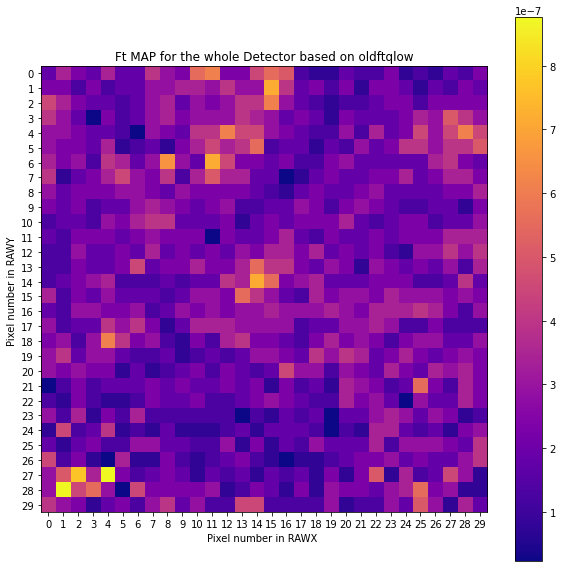

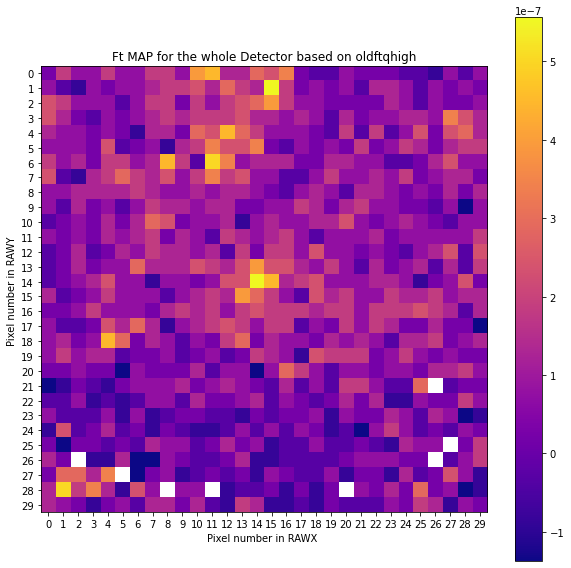

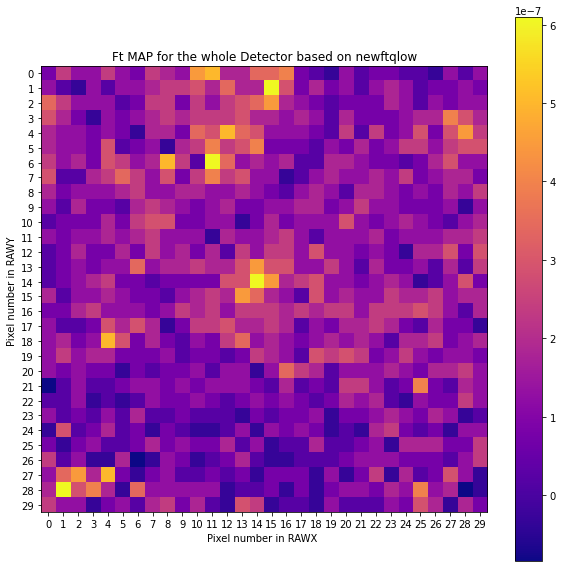

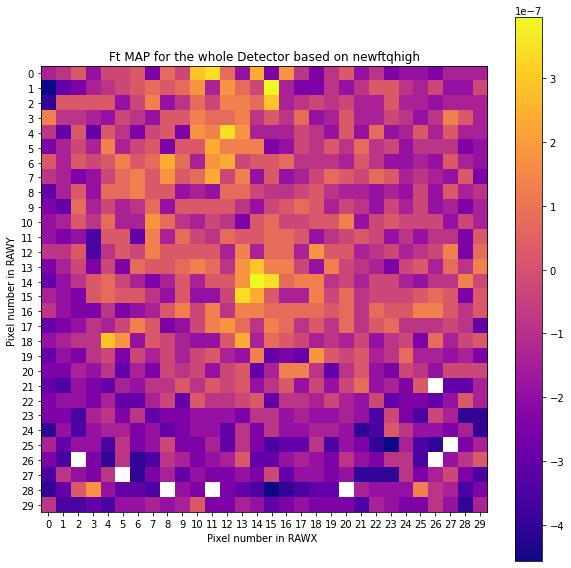

In [63]:
def plot(var,namelist):
  
  matplotlib.rc('xtick', labelsize=10) 
  matplotlib.rc('ytick', labelsize=10) 
  x_axis = np.arange(0,30,1)
  y_axis =np.arange(0,30,1)

  for (a,b) in zip(var,namelist):
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(a, cmap="plasma")
    bar = plt.colorbar(im)

    ax.set_xlabel("Pixel number in RAWX ")
    ax.set_ylabel("Pixel number in RAWY ")

    ax.set_yticks(np.arange(len(y_axis)))
    ax.set_xticks(np.arange(len(x_axis)))

    ax.set_title("Ft MAP for the whole Detector based on {}".format(b) )
    plt.savefig("graph {}.jpg".format(b))
    np.savetxt("text {}.txt".format(b), a)
    print()
    print()


  
plot(var,namelist)